In [1]:
import pandas as pd
from minicons import cwe
from torch.utils.data import DataLoader
import torch
from collections import defaultdict
from tqdm import tqdm
import re
from model import FFNModule, FeatureNormPredictor, FFNParams, TrainingParams

/home/jjr4354/.conda/envs/jwalenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# tuples of stems and themes
templates = [
    ("sent", "the letter"),
    ("mailed", "some cookies"),
    ("ordered", "50 bouquets of roses"),
    ("brought", "a loaf of bread"),
    ("delivered", "the message"),
    ("faxed", "the documents"),
]

# list of subjects
subjects = ["John", "Mary", "Nancy", "Peter", "I"]
# list of recipients
peoplaces = ["London", "Paris", "Austin", "Sydney", "Jordan", "Brooklyn", "Savannah", "Dallas", "Florence", "Jackson", "Madison", "Charlotte", "Alexandria", "Raleigh", "Dakota"]

In [3]:
# generate pairs
data = defaultdict(list)
for peoplace in peoplaces:
    for subject in subjects:
        for template in templates:
            data['DO'].append(f"{subject} {template[0]} {peoplace} {template[1]}.")
            data['PO'].append(f"{subject} {template[0]} {template[1]} to {peoplace}.")
            data['recipient'].append(peoplace)

df = pd.DataFrame(dict(data))
df.to_csv("data/generated_pairs.csv")

In [25]:
# do prediction
df = pd.read_csv("data/generated_pairs.csv")

do_list = df[['DO','recipient']].values.tolist()
po_list = df[['PO','recipient']].values.tolist()

datasets = [do_list, po_list]

# extract all the embeddings and do predictions
lms = ['roberta-base', 'bert-base-uncased', 'albert-xxlarge-v2']
# hierarchy is model: dataset: layer: average feature prediction vector
preds_per_model = defaultdict(list)
num_features = 65 # binder
for model in lms:
    # load lm for embedding extraction
    lm = cwe.CWE(model)
    # load my models
    nick_name = str.split(model, "-")[0]
    classifiers = []
    for layer in range(13):
        path = f"../saved_models/{nick_name}_models_all/{nick_name}_to_binder_layer{layer}.ckpt"
        my_mo = FeatureNormPredictor.load_from_checkpoint(
            checkpoint_path=path,
            map_location={"cuda:1":"cpu", "cuda:2":"cpu"}
        )
        my_mo.eval()
        classifiers.append(my_mo)
    
    for set in datasets:
        # initialize a dictionary for our predictions to live in
        layerwise_predictions = defaultdict(lambda : torch.zeros(num_features).unsqueeze(0))

        dl = DataLoader(set, batch_size=16)
        # tqdm is progress bar
        for batch in tqdm(dl):
            sentences, words = batch
            batched_query = list(zip(sentences, words))
            # we have a 3d tensor: layer: sentence: embedding
            layer_embs = lm.extract_representation(batched_query, layer='all')
            for layer, embs in enumerate(layer_embs):
                for i in range(0, embs.size(0)):
                    emb = embs[i]
                    # this is a nan check
                    if layer == 0:
                        query = batched_query[i]
                        if emb.isnan().any():
                            print("nan detected in extracted embeddings, offending query:")
                            print(f"query: {query}")
                            raise Exception("nan found in embedding")
                    # perform prediction on this embedding
                    my_mo = classifiers[layer]
                    with torch.no_grad(): pred = torch.nn.functional.relu(my_mo(emb))
                    pred = pred.squeeze(0)
                    # add this to the calculation
                    layerwise_predictions[layer] += (pred/len(set))

        layerwise_predictions = dict(layerwise_predictions)
        preds_per_model[model].append(layerwise_predictions)



100%|██████████| 29/29 [00:58<00:00,  2.01s/it]


In [26]:
label_path = "../saved_models/bert_models_all/bert_to_binder_layer8.txt"
with open (label_path, "r") as file:
    labels = [line.rstrip() for line in file.readlines()]
lms = ['albert-xxlarge-v2', 'bert-base-uncased', 'roberta-base']

In [27]:
# a loop to save data in csvs
for model in lms:
    nick_name = str.split(model, "-")[0]
    for layer in range(13):
        data = pd.DataFrame({
            "feature": labels,
            "DO": preds_per_model[model][0][layer].detach().tolist()[0],
            "PO": preds_per_model[model][1][layer].detach().tolist()[0]
        })
        data.loc[:,'DO-PO'] = data["DO"] - data["PO"]
        data = data.sort_values(by='DO-PO', ascending=True)

        data.to_csv(f'results/generated/csvs/{nick_name}{layer}.csv')

In [28]:
# data vis time ヾ(⌐■_■)ノ♪
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

In [29]:
# from intuition

humany_things = {"Biomotion", "Body", "Human", "Face", "Speech"}
placey_things = {"Landmark", "Scene"}

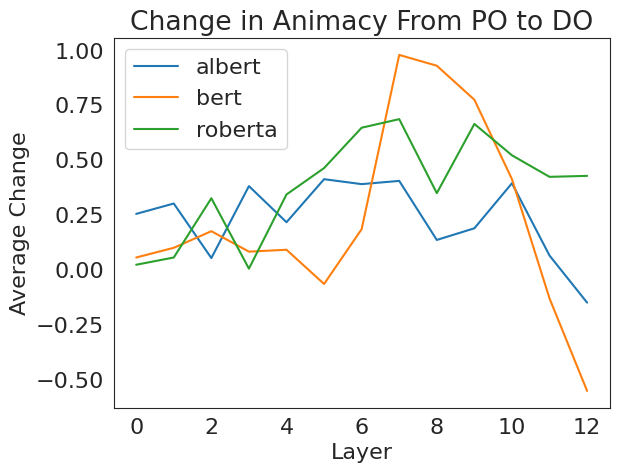

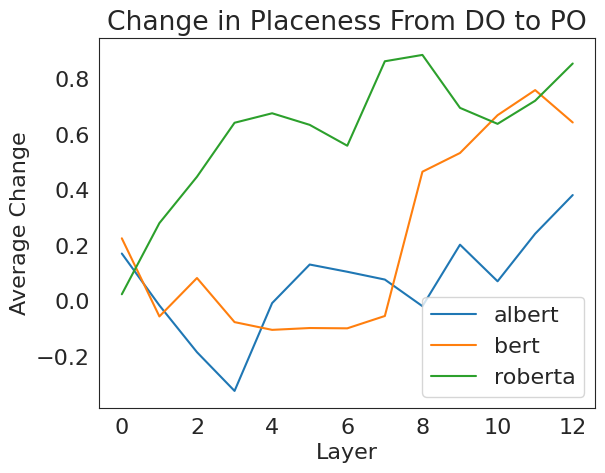

In [35]:
# calculate metric : humany shift experimentation
hu_values = defaultdict(list)
pl_values = defaultdict(list)
for model in lms:
    nick_name = str.split(model, "-")[0]
    for layer in range(13):
        data = pd.read_csv(f"results/generated/csvs/{nick_name}{layer}.csv")
        # filter for just the humany things
        data_hu = data[data['feature'].isin(humany_things)]
        data_pl = data[data['feature'].isin(placey_things)]
        # find the mean of the change for DO and PO
        hu_values[nick_name].append(data_hu.loc[:, 'DO-PO'].mean())
        pl_values[nick_name].append(data_pl.loc[:, 'DO-PO'].mean()*-1)

plt.figure()
for model in lms:
    nick_name = str.split(model, "-")[0]
    plt.plot(list(range(13)),hu_values[nick_name], label = nick_name)
plt.legend()
plt.title("Change in Animacy From PO to DO")
plt.ylabel("Average Change")
plt.xlabel("Layer")
plt.show()
plt.close()
plt.figure()
for model in lms:
    nick_name = str.split(model, "-")[0]
    plt.plot(list(range(13)),pl_values[nick_name], label = nick_name)
plt.legend()
plt.title("Change in Placeness From DO to PO")
plt.ylabel("Average Change")
plt.xlabel("Layer")
plt.show()
plt.close()

In [31]:
for thing in humany_things:
    # calculate metric : humany shift experimentation
    values = defaultdict(list)
    for model in lms:
        nick_name = str.split(model, "-")[0]
        for layer in range(13):
            data = pd.read_csv(f"results/generated/csvs/{nick_name}{layer}.csv")
            # filter for just the humany things
            data = data[data['feature']==thing]
            # find the mean of the change for DO and PO
            values[nick_name].append(data.loc[:, 'DO-PO'].mean())

    plt.figure()
    for model in lms:
        nick_name = str.split(model, "-")[0]
        plt.plot(list(range(13)),values[nick_name], label = nick_name)
    plt.legend()
    plt.title(f"Change in {thing} From PO to DO (Positive Expected)")
    plt.ylabel("Average Change")
    plt.xlabel("Layer")
    plt.savefig(f"results/generated/by_feature/{thing}.png")
    plt.close()


In [34]:
candidates = ["roberta7", "bert8", "bert9"]

for candidate in candidates:
    data = pd.read_csv(f"results/generated/csvs/{candidate}.csv")

    filter = humany_things.union(placey_things)
    data = data[data['feature'].isin(filter)]
    data.to_csv(f"results/generated/{candidate}.csv")